<a href="https://colab.research.google.com/github/DennisKevogo/-Algerian-Forest-Fires-/blob/main/Network_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import libraries
%pip install basemap
%pip install openpyxl
%pip install -U kaleido
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite
import collections
from IPython.display import Image
from mpl_toolkits.basemap import Basemap as Basemap
import numpy as np
import plotly.graph_objects as go
import kaleido
from collections import Counter
import seaborn as sns
from scipy import stats
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#read data
flights=pd.read_excel('/content/Flight Data.xlsx')
airports=pd.read_csv('/content/Airports.csv', encoding='latin-1')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#
flights.head()

,Source,Source City,Source Country,Target,Target City,Target Country,Weight
0,FNC,Funchal,Portugal,PXO,Porto Santo,Portugal,9864
1,PXO,Porto Santo,Portugal,FNC,Funchal,Portugal,9864
2,AEP,Buenos Aires,Argentina,MVD,Montevideo,Uruguay,1463
3,MVD,Montevideo,Uruguay,AEP,Buenos Aires,Argentina,1463
4,AEP,Buenos Aires,Argentina,ROS,Rosario (AR),Argentina,2261


# New Section

In [5]:
#
airports.head()

,id,label,country,Lat,Lon
0,BIN,Bamyan,Afghanistan,34.800000,67.816667
1,BST,Lashkar Gah,Afghanistan,31.582998,64.360000
2,CCN,Chaghcharan,Afghanistan,34.516701,65.250001
3,DAZ,Darwaz,Afghanistan,38.466667,70.883333
4,FAH,Farah,Afghanistan,32.391730,62.096819


In [6]:
# Display info about the dataframes
print("\nAirports DataFrame Info:")
print(airports.info())

print("\nFlights DataFrame Info:")
print(flights.info())


Airports DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9033 entries, 0 to 9032
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       9033 non-null   object 
 1   label    9033 non-null   object 
 2   country  9033 non-null   object 
 3   Lat      9033 non-null   float64
 4   Lon      9033 non-null   float64
dtypes: float64(2), object(3)
memory usage: 353.0+ KB
None

Flights DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60470 entries, 0 to 60469
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Source          60470 non-null  object
 1   Source City     60470 non-null  object
 2   Source Country  60470 non-null  object
 3   Target          60470 non-null  object
 4   Target City     60470 non-null  object
 5   Target Country  60470 non-null  object
 6   Weight          60470 non-null  int64 
dtypes: int64(

In [7]:
#correct spelling of United states in airports for records with unites states
airports['country']=airports['country'].str.replace('Unites States','United States')

In [8]:
#extract the 4 countries of interest from internal flights
countries_of_interest = ['USA', 'China', 'United Kingdom', 'Australia']
country_datasets = {}

for country in countries_of_interest:
    # Filter flights where both Source Country and Target Country are the same
    country_flights = flights[
        (flights['Source Country'] == country) &
        (flights['Target Country'] == country)
    ]
    country_datasets[country] = country_flights

# Save the filtered datasets to separate CSV files
for country, dataset in country_datasets.items():
    dataset.to_csv(f'{country}_internal_flights.csv', index=False)

#summary
for country in countries_of_interest:
    print(f"{country}: {len(country_datasets[country])} internal flights")


USA: 13263 internal flights
China: 2602 internal flights
United Kingdom: 638 internal flights
Australia: 1043 internal flights


In [17]:
# Strip whitespace from column names
airports.columns = airports.columns.str.strip()
print(airports.columns.tolist())
airports.rename(columns={'Lat ': 'Lat', 'Lon ': 'Lon'}, inplace=True)



['id', 'label', 'country', 'Lat', 'Lon']


In [15]:
#extract airports of the 4 countries
countries_of_interest = ['United States', 'China', 'United Kingdom', 'Australia']

# Filter airports for each country
country_airports = {}

for country in countries_of_interest:
    # Filter airports for the current country
    country_specific_airports = airports[airports['country'] == country]
    country_airports[country] = country_specific_airports

    # Save the filtered data for each country (optional)
    country_specific_airports.to_csv(f'{country}_airports.csv', index=False)

#summary of extracted airports
for country in countries_of_interest:
    print(f"{country}: {len(country_airports[country])} airports extracted")

United States: 1976 airports extracted
China: 242 airports extracted
United Kingdom: 135 airports extracted
Australia: 609 airports extracted


In [11]:
!pip uninstall kaleido
!pip install --no-cache-dir kaleido

Found existing installation: kaleido 0.2.1
Uninstalling kaleido-0.2.1:
  Would remove:
    /usr/local/lib/python3.11/dist-packages/kaleido-0.2.1.dist-info/*
    /usr/local/lib/python3.11/dist-packages/kaleido/*
Proceed (Y/n)? Y
  Successfully uninstalled kaleido-0.2.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 174.4 MB/s eta 0:00:00


In [12]:
#Q1(Interconnectivity Graphs for each country)
def create_interactive_flight_map(flights_file, airports_file, country):
    # Data loading
    flights = pd.read_csv(flights_file)
    airports = pd.read_csv(airports_file)

    # Directed graph
    G = nx.DiGraph()

    # Add nodes with geospatial coordinates
    for _, row in airports.iterrows():
        G.add_node(row['id'], pos=(row['Lon'], row['Lat']), label=row['label'])

    # Add edges with weights
    for _, row in flights.iterrows():
        if row['Source'] in G.nodes and row['Target'] in G.nodes:
            G.add_edge(row['Source'], row['Target'], weight=row['Weight'])

    # Position data
    pos = nx.get_node_attributes(G, 'pos')

    # Centrality calculations
    degrees = dict(G.degree())
    eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000, weight='weight')
    betweenness_centrality = nx.betweenness_centrality(G, normalized=True, weight='weight')
    closeness_centrality = nx.closeness_centrality(G)
    max_degree = max(degrees.values())

    # Save centrality results to CSV
    centrality_data = [
        {
            'Airport': G.nodes[node]['label'],
            'Degree': degrees[node],
            'Eigenvector Centrality': eigenvector_centrality[node],
            'Betweenness Centrality': betweenness_centrality[node],
            'Closeness Centrality': closeness_centrality[node]
        }
        for node in G.nodes()
    ]
    pd.DataFrame(centrality_data).to_csv(f'{country}_centrality_scores.csv', index=False)

    # Create edge traces (curved lines)
    edge_traces = []
    edge_weights = [G.edges[edge]['weight'] for edge in G.edges()]
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        mid_x = (x0 + x1) / 2
        mid_y = (y0 + y1) / 2
        curve_strength = 0.2
        control_x = mid_x + (y1 - y0) * curve_strength
        control_y = mid_y - (x1 - x0) * curve_strength
        weight = G.edges[edge]['weight']
        normalized_weight = (weight / max(edge_weights)) * 2

        edge_trace = go.Scattergeo(
            lon=[x0, control_x, x1],
            lat=[y0, control_y, y1],
            mode='lines',
            line=dict(
                width=normalized_weight,
                color='rgba(140, 86, 75, 0.4)'
            ),
            hoverinfo='none',
            showlegend=False
        )
        edge_traces.append(edge_trace)

    # Create node trace
    node_trace = go.Scattergeo(
        lon=[pos[node][0] for node in G.nodes()],
        lat=[pos[node][1] for node in G.nodes()],
        mode='markers',
        hoverinfo='text',
        text=[
            f"Airport: {G.nodes[node]['label']}<br>" +
            f"Degree: {degrees[node]}<br>" +
            f"Eigenvector Centrality: {eigenvector_centrality[node]:.3f}<br>" +
            f"Betweenness Centrality: {betweenness_centrality[node]:.3f}<br>" +
            f"Closeness Centrality: {closeness_centrality[node]:.3f}"
            for node in G.nodes()
        ],
        marker=dict(
            size=[(degrees[node] / max_degree) * 20 + 5 for node in G.nodes()],
            color=[eigenvector_centrality[node] for node in G.nodes()],
            colorscale='Viridis',
            showscale=True,
            colorbar=dict(
                title='Eigenvector Centrality',
                thickness=15,
                xanchor='left',
                titleside='right'
            ),
            line=dict(
                color='white',
                width=1
            )
        )
    )

    # Create figure with edge and node traces
    fig = go.Figure(data=edge_traces + [node_trace])
    fig.update_layout(
        title=dict(
            text=f'{country} Airline Network (Internal Flights)',
            font=dict(size=24),
            x=0.5,
            y=0.95
        ),
        showlegend=False,
        geo=dict(
            scope='world',
            projection_type='mercator',
            showland=True,
            landcolor='rgb(243, 243, 243)',
            countrycolor='rgb(204, 204, 204)',
            showocean=True,
            oceancolor='rgb(230, 230, 250)',
            showlakes=True,
            lakecolor='rgb(230, 230, 250)',
            showcountries=True,
            resolution=50
        ),
        height=800,
        margin=dict(r=0, t=30, l=0, b=0)
    )

    return fig

# Define country files
country_files = {
    'USA': ('USA_internal_flights.csv', 'United States_airports.csv'),
    'China': ('China_internal_flights.csv', 'China_airports.csv'),
    'United Kingdom': ('United Kingdom_internal_flights.csv', 'United Kingdom_airports.csv'),
    'Australia': ('Australia_internal_flights.csv', 'Australia_airports.csv')
}

# Generate visualizations and save results
for country, (flights_file, airports_file) in country_files.items():
    fig = create_interactive_flight_map(flights_file, airports_file, country)
    fig.show()
    fig.write_image(f"{country.replace(' ', '_')}_flight_network.png", width=1920, height=1080, scale=2)
    print(f"Saved {country}_flight_network.png and centrality data for {country}.")


Saved USA_flight_network.png and centrality data for USA.


Saved China_flight_network.png and centrality data for China.


Saved United Kingdom_flight_network.png and centrality data for United Kingdom.


Saved Australia_flight_network.png and centrality data for Australia.



Analyzing USA network...
Assortativity coefficient: -0.223
Maximum core size: 647

Analyzing China network...
Assortativity coefficient: -0.396
Maximum core size: 110

Analyzing United Kingdom network...
Assortativity coefficient: -0.145
Maximum core size: 58

Analyzing Australia network...
Assortativity coefficient: -0.225
Maximum core size: 154


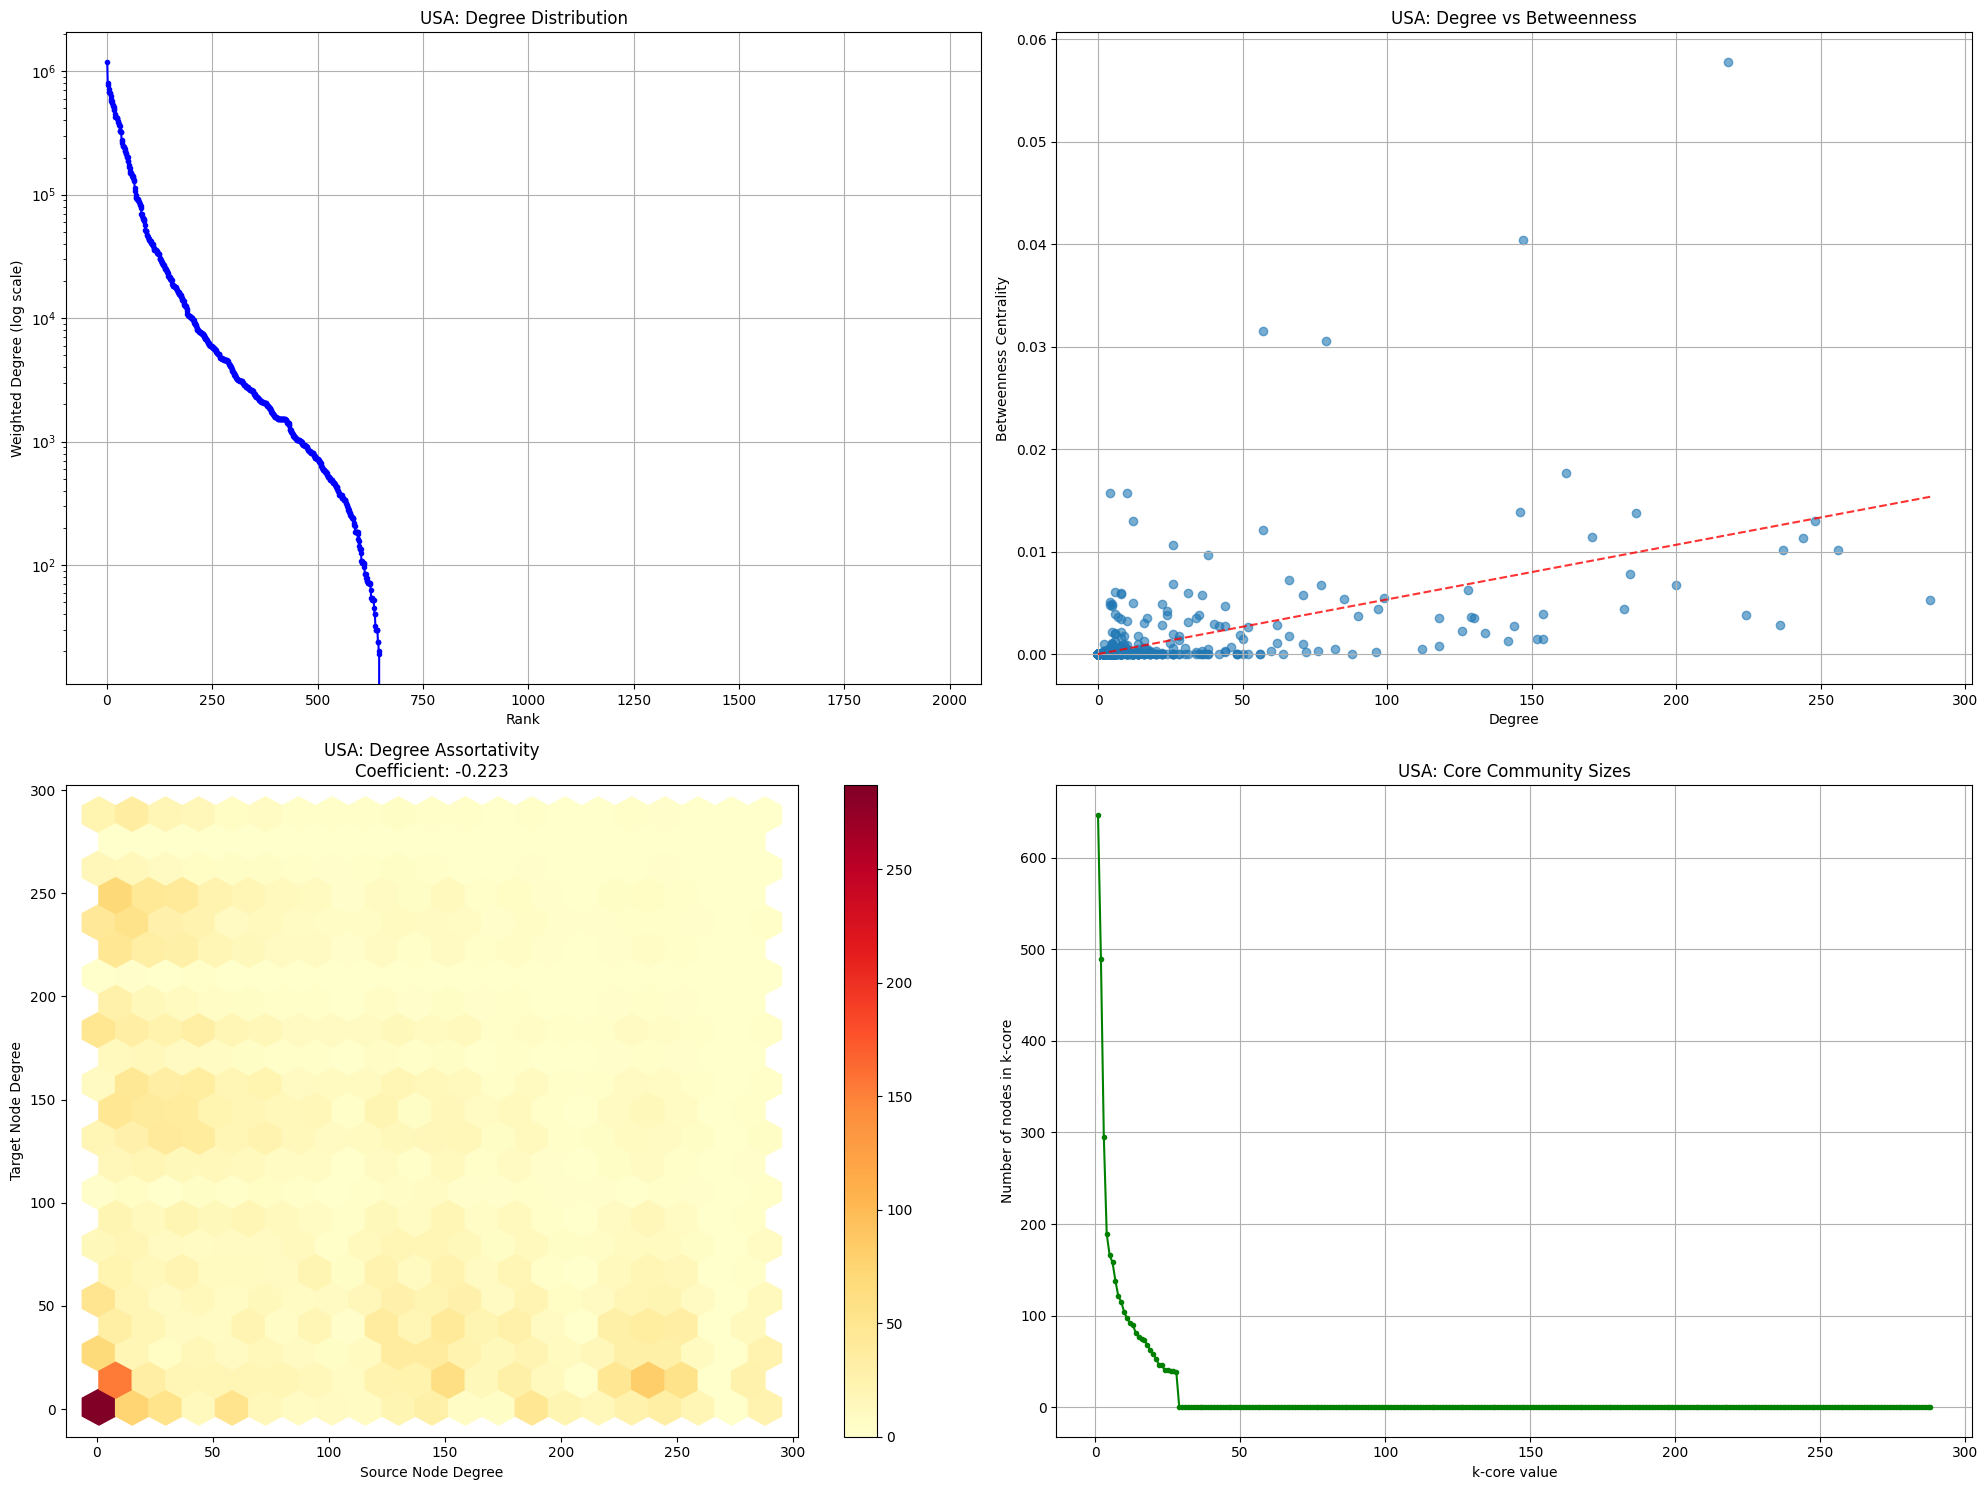

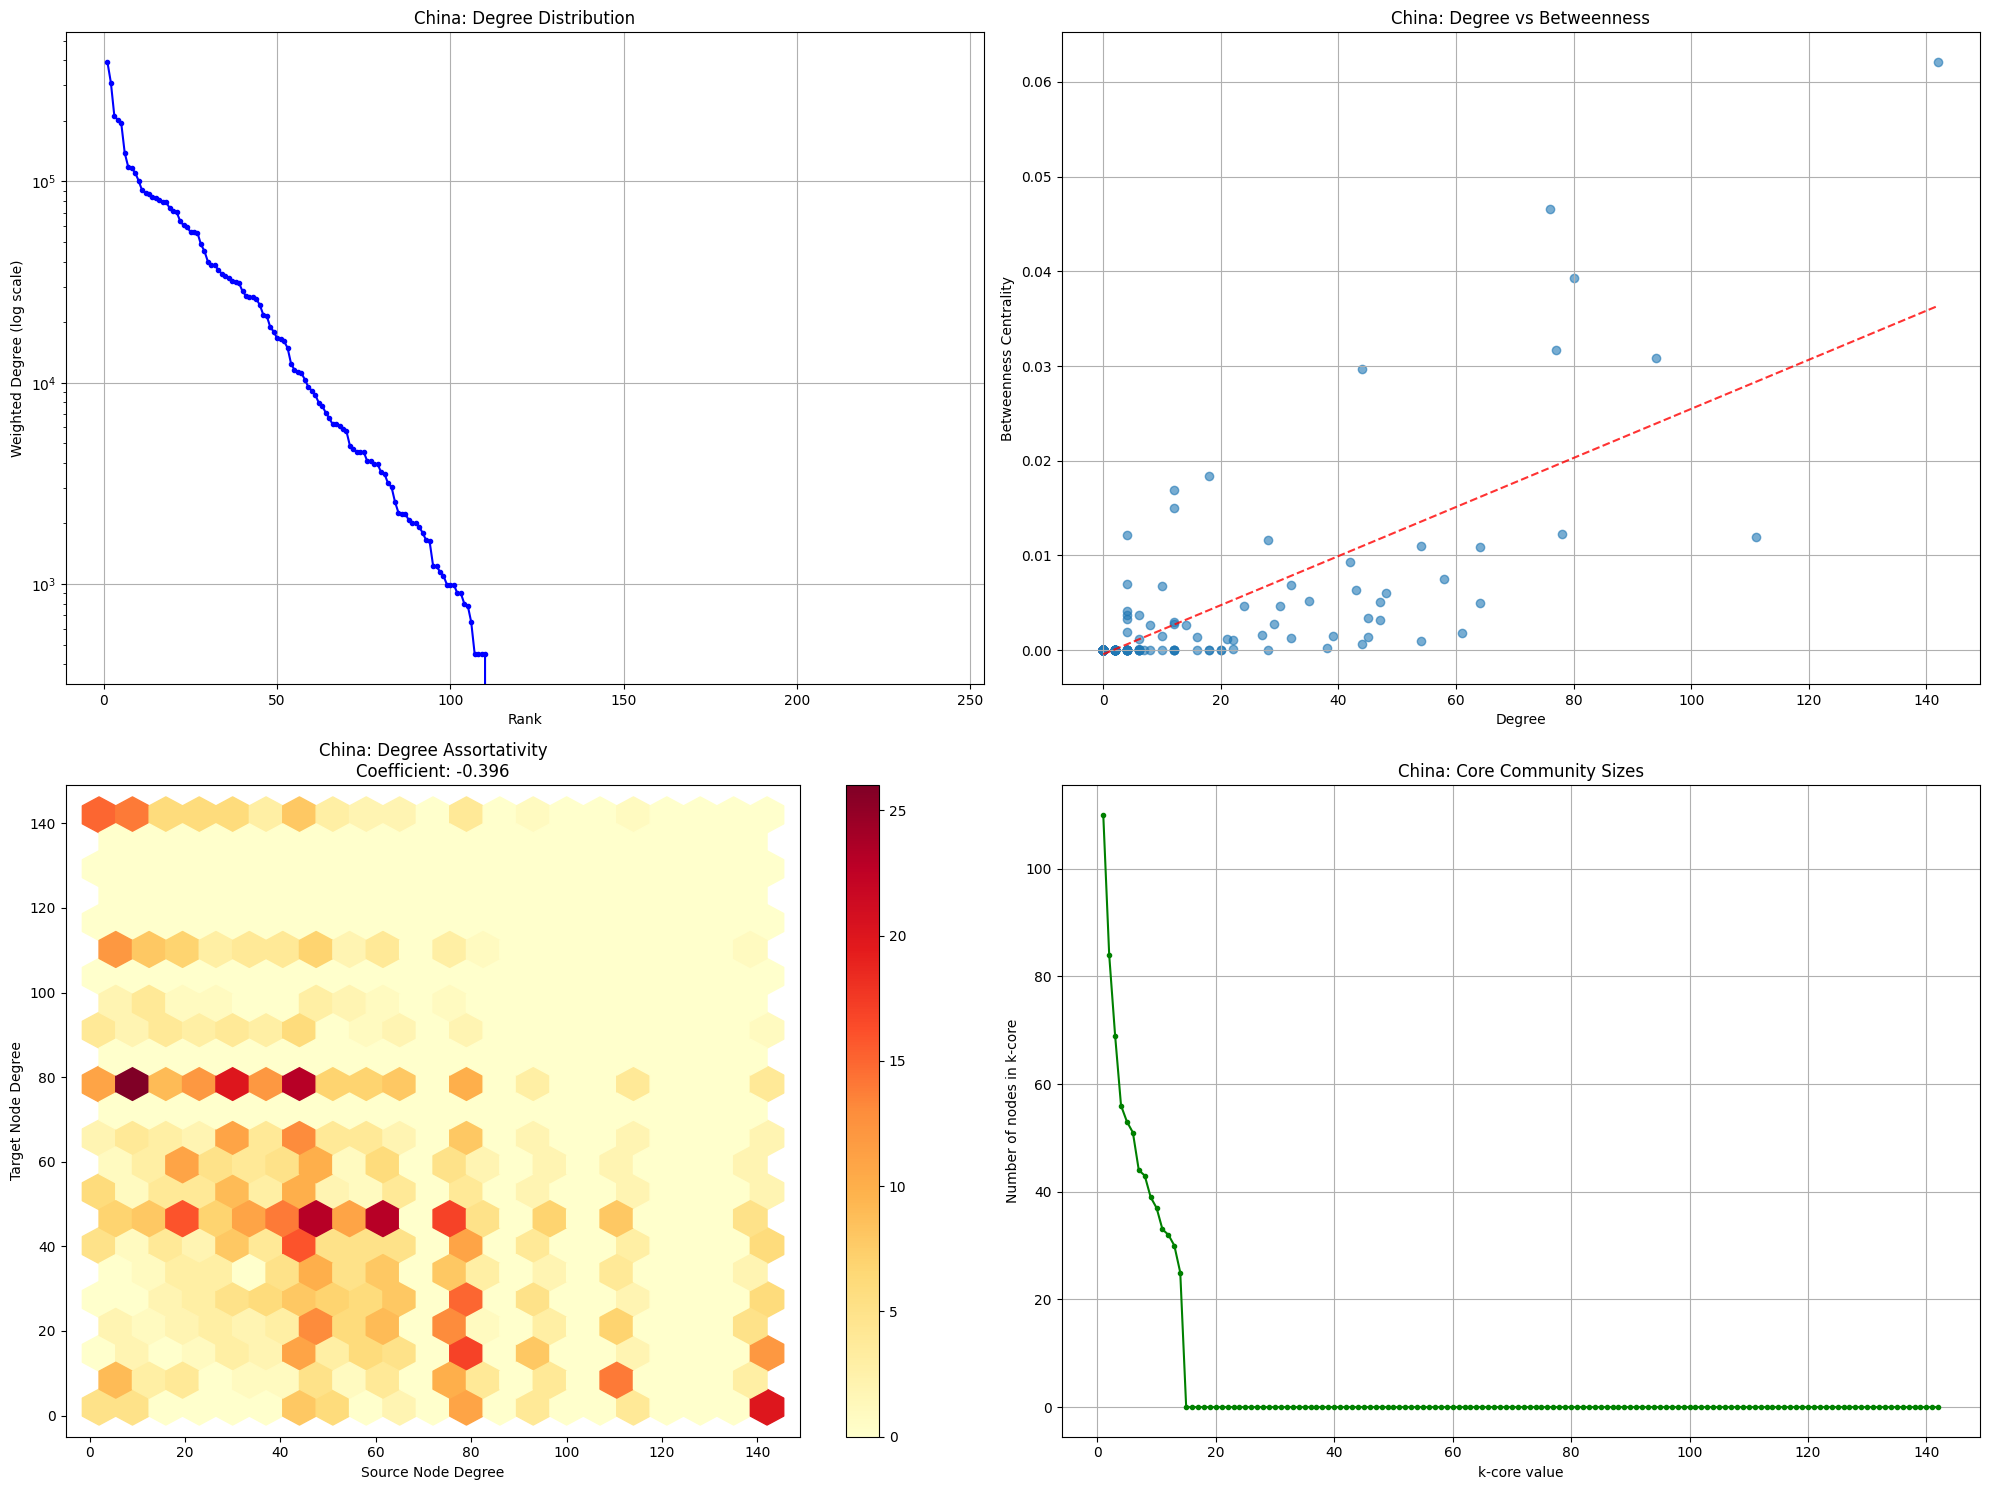

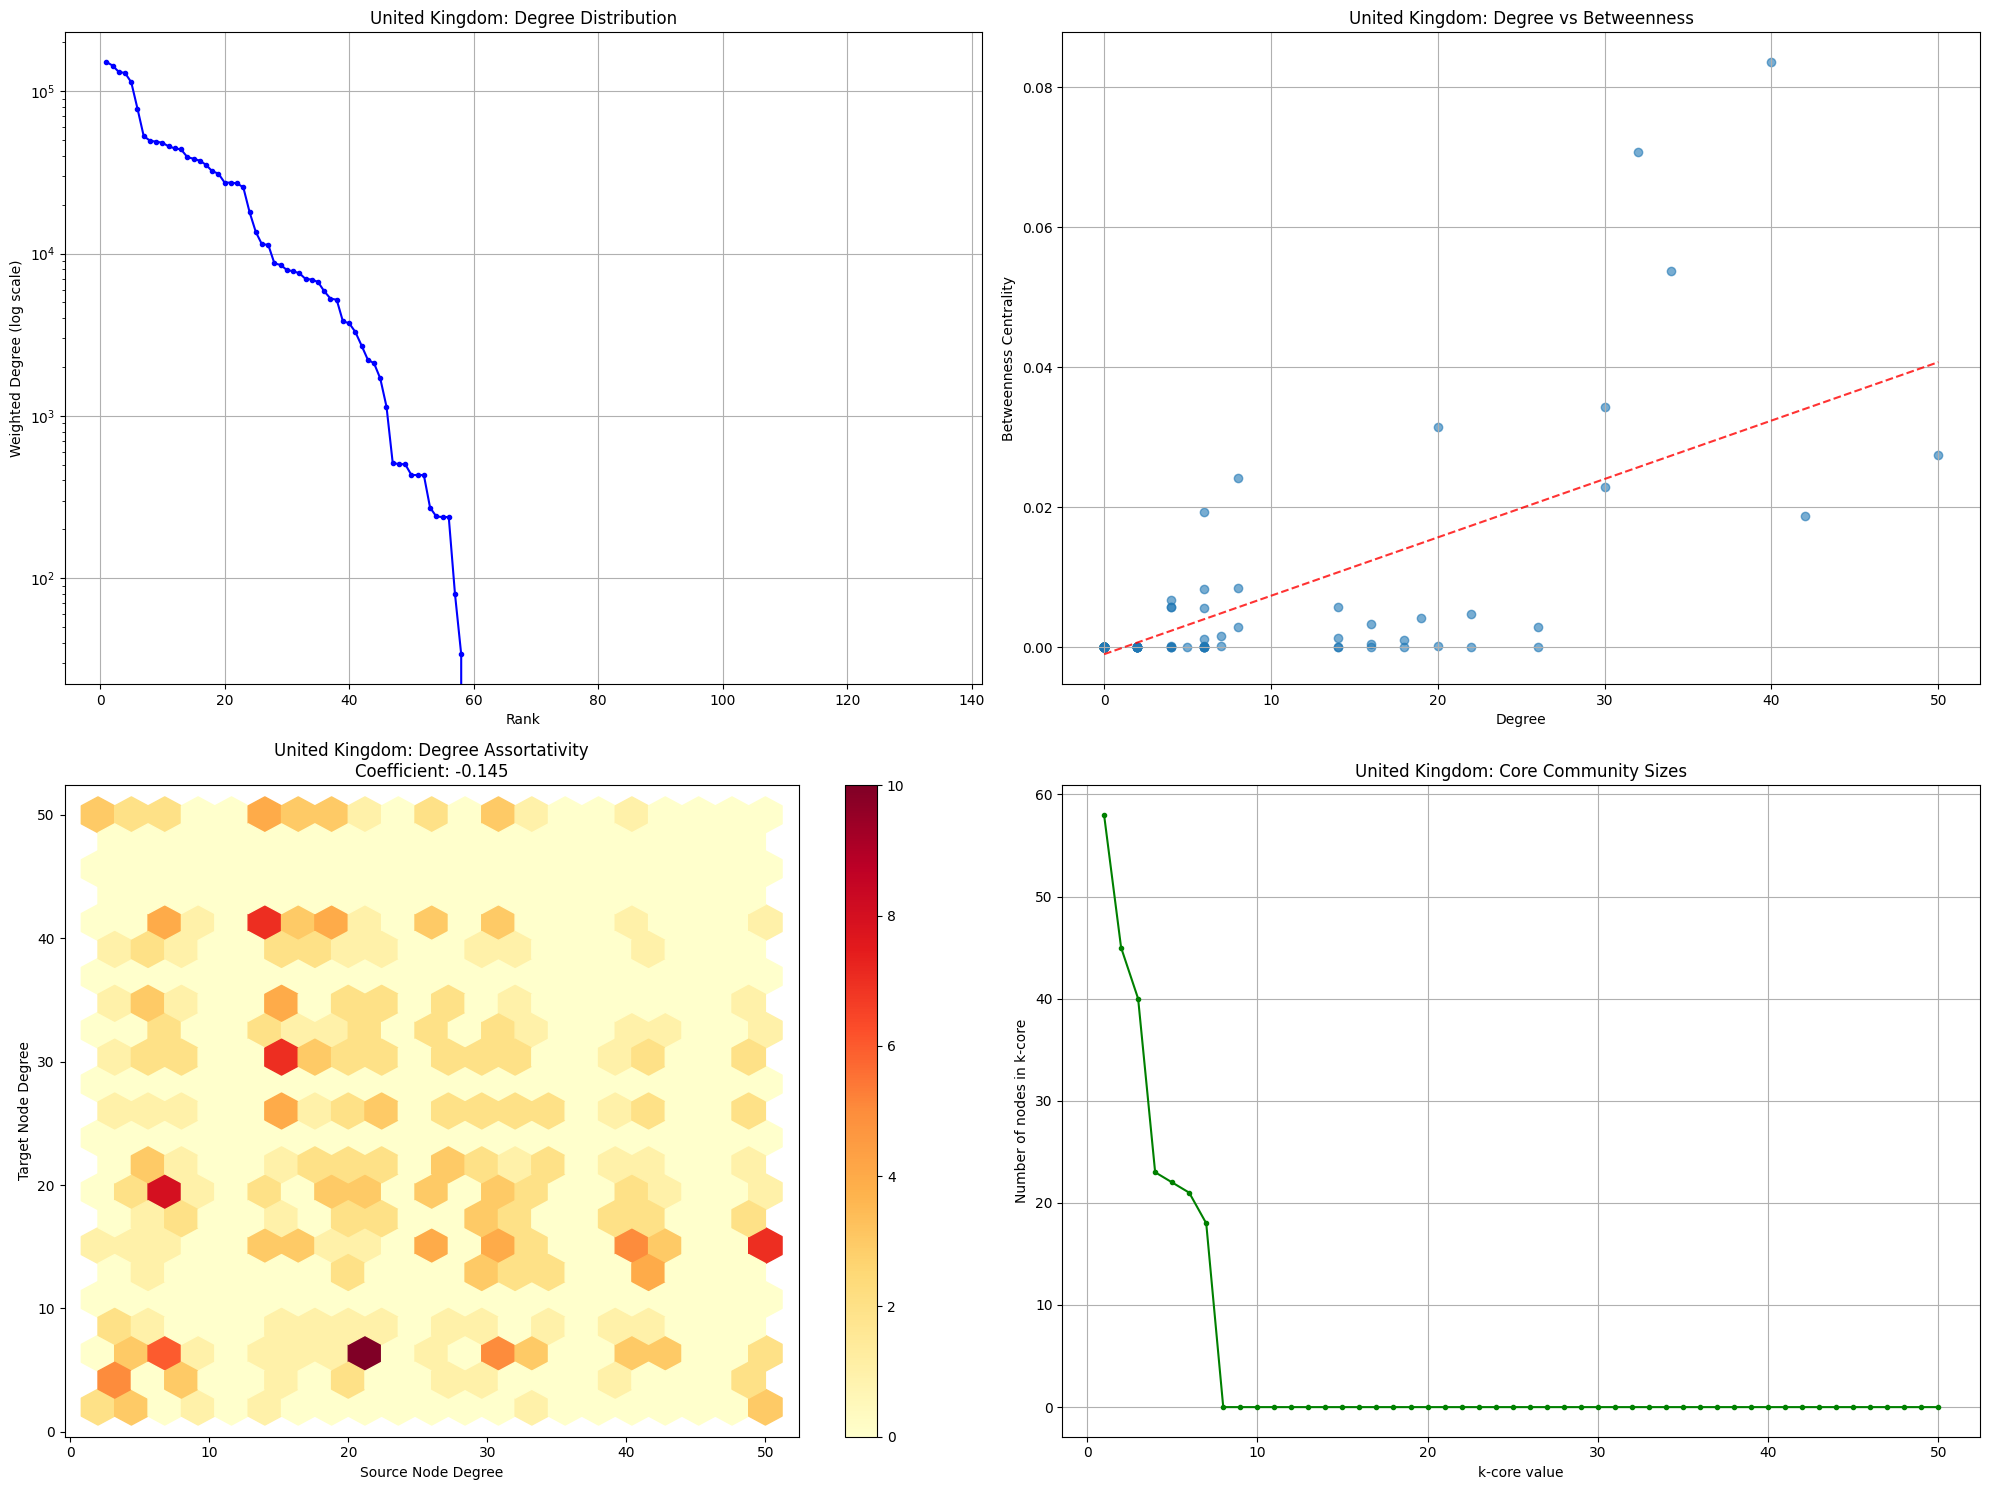

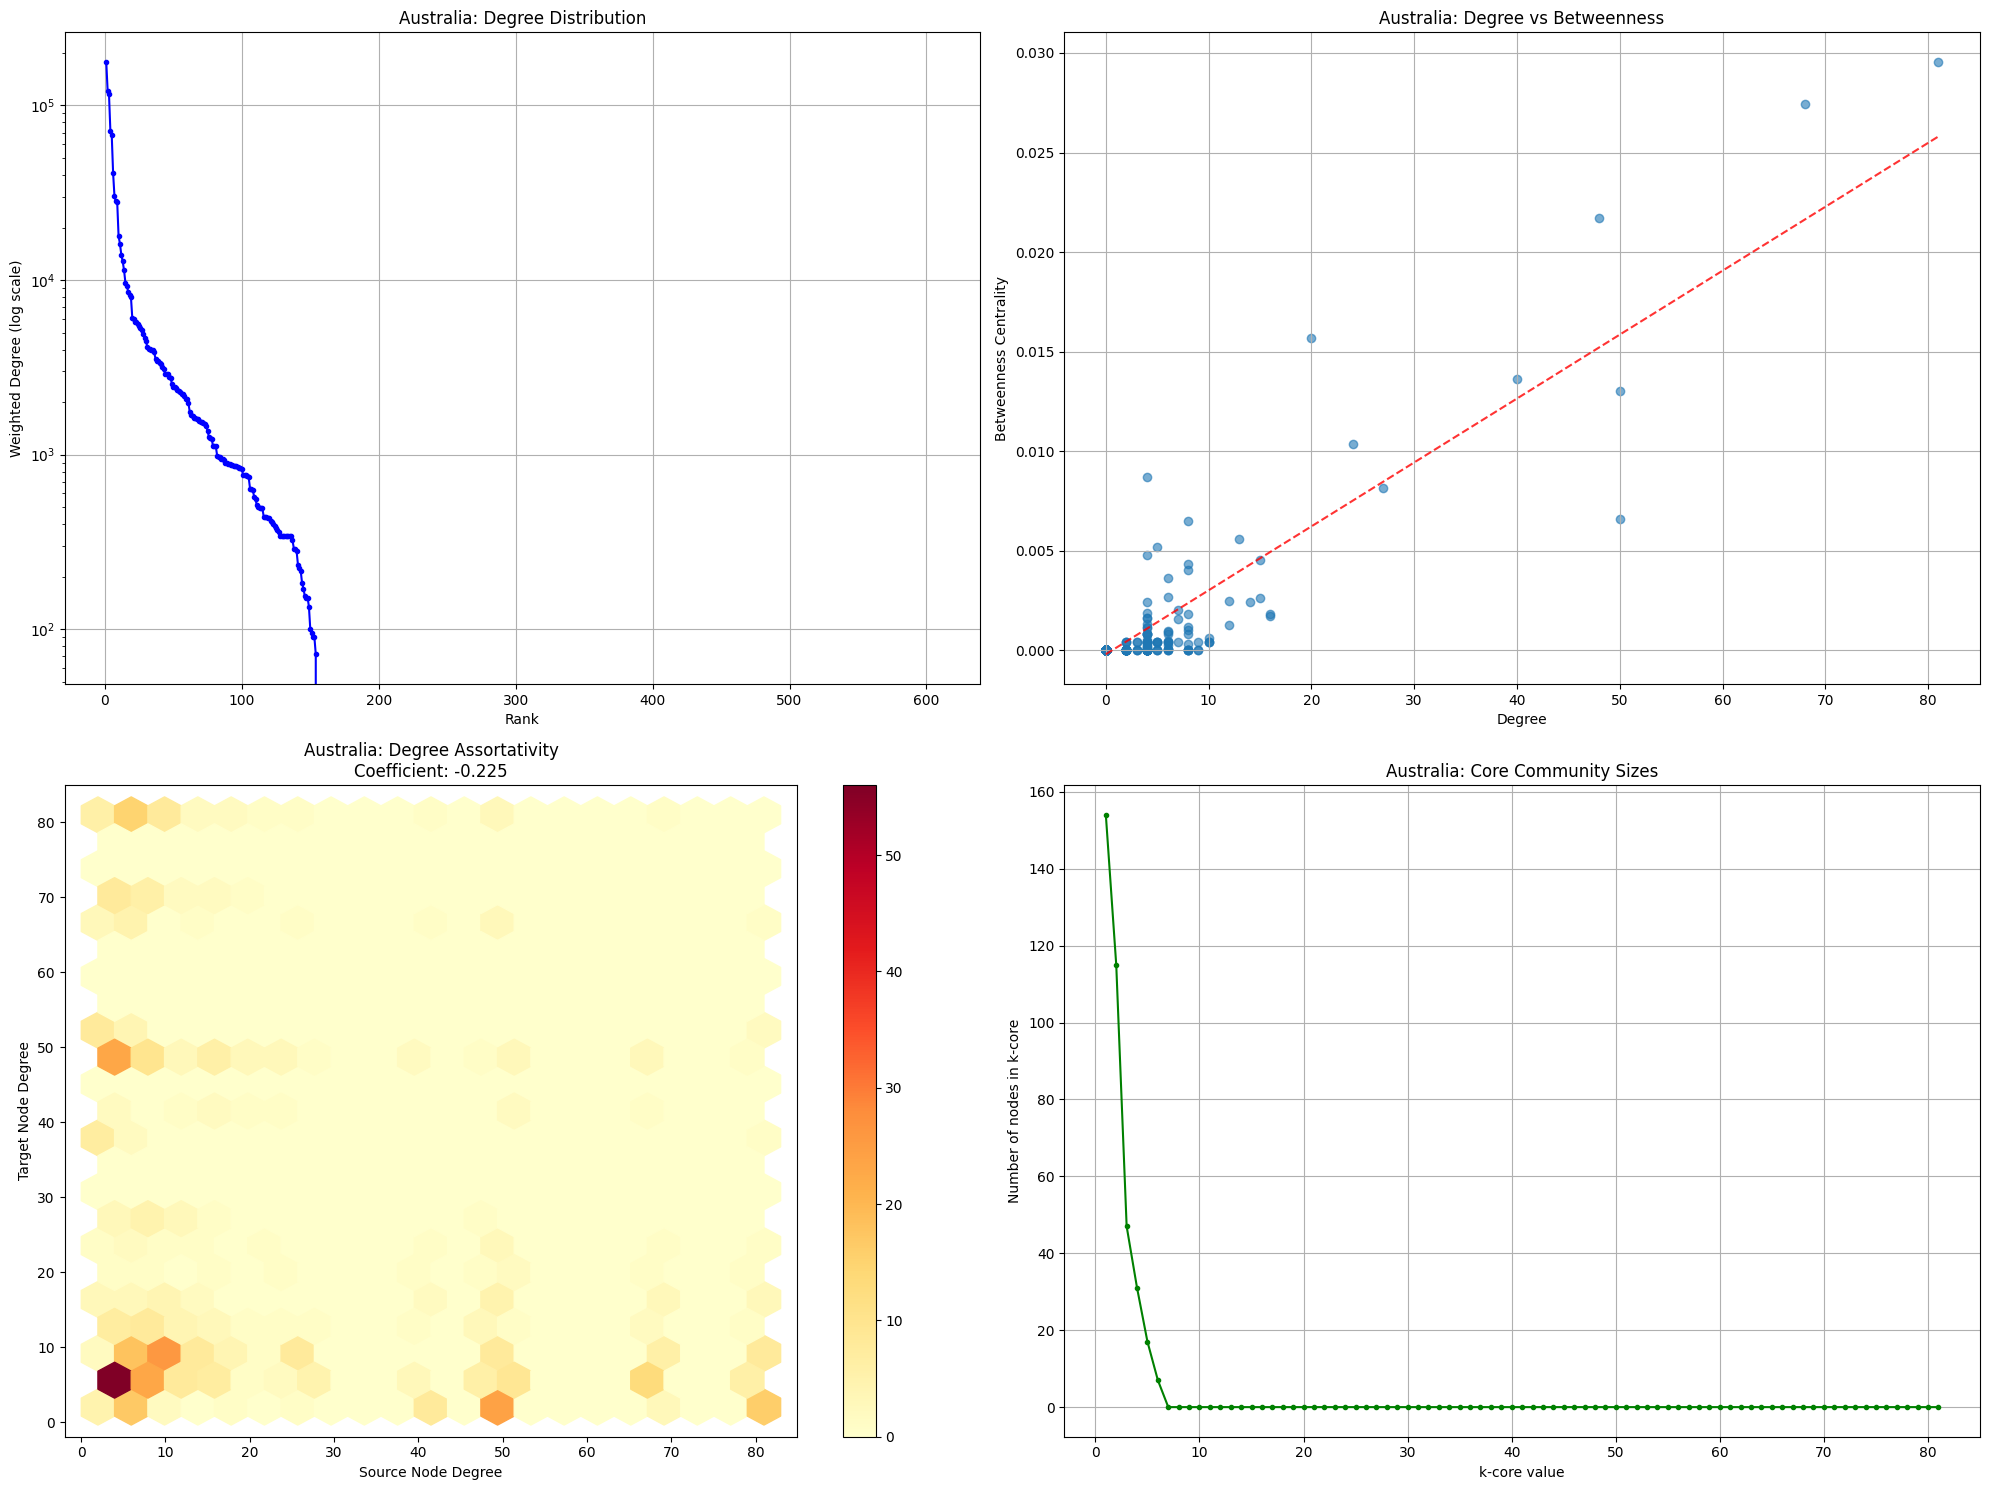

In [14]:
###Q2(All Metrics)
def create_network_analysis_plots(flights_file, airports_file, country_name):
    # Read data and create network
    flights = pd.read_csv(flights_file)
    airports = pd.read_csv(airports_file)

    G = nx.DiGraph()
    for _, row in airports.iterrows():
        G.add_node(row['id'], pos=(row['Lon'], row['Lat']), label=row['label'])

    for _, row in flights.iterrows():
        if row['Source'] in G.nodes and row['Target'] in G.nodes:
            G.add_edge(row['Source'], row['Target'], weight=row['Weight'])

    # Create figure with subplots
    fig = plt.figure(figsize=(20, 15))

    #a. Degree Distribution (log-scale)
    ax1 = plt.subplot(221)

    # Calculate weighted degrees
    weighted_degrees = dict()
    for node in G.nodes():
        weighted_degrees[node] = sum(w['weight'] for _, _, w in G.edges(node, data=True))

    # Sort degrees in descending order
    sorted_degrees = sorted(weighted_degrees.values(), reverse=True)
    ranks = range(1, len(sorted_degrees) + 1)

    ax1.plot(ranks, sorted_degrees, 'bo-', markersize=3)
    ax1.set_yscale('log')
    ax1.set_xlabel('Rank')
    ax1.set_ylabel('Weighted Degree (log scale)')
    ax1.set_title(f'{country_name}: Degree Distribution')
    ax1.grid(True)

    #b. Degree vs Betweenness
    ax2 = plt.subplot(222)

    # Calculate metrics
    degrees = dict(G.degree())
    betweenness = nx.betweenness_centrality(G, weight='weight')

    #scatter plot
    ax2.scatter(list(degrees.values()),
                list(betweenness.values()),
                alpha=0.6)

    # Add trend line
    z = np.polyfit(list(degrees.values()), list(betweenness.values()), 1)
    p = np.poly1d(z)
    ax2.plot(sorted(degrees.values()),
             p(sorted(degrees.values())),
             "r--", alpha=0.8)

    ax2.set_xlabel('Degree')
    ax2.set_ylabel('Betweenness Centrality')
    ax2.set_title(f'{country_name}: Degree vs Betweenness')
    ax2.grid(True)

    #c. Assortativity
    ax3 = plt.subplot(223)

    #degree correlations for connected nodes
    x = []
    y = []
    for edge in G.edges():
        x.append(degrees[edge[0]])
        y.append(degrees[edge[1]])

    #assortativity coefficient
    assortativity = nx.degree_assortativity_coefficient(G)

    #scatter plot with hexbin for better visualization
    hb = ax3.hexbin(x, y, gridsize=20, cmap='YlOrRd')
    plt.colorbar(hb, ax=ax3)

    ax3.set_xlabel('Source Node Degree')
    ax3.set_ylabel('Target Node Degree')
    ax3.set_title(f'{country_name}: Degree Assortativity\nCoefficient: {assortativity:.3f}')

    #d. Core Community Size
    ax4 = plt.subplot(224)

    #k-core decomposition
    k_core_sizes = []
    max_k = max(degrees.values())
    k_values = range(1, max_k + 1)

    for k in k_values:
        k_core = nx.k_core(G.to_undirected(), k=k)
        k_core_sizes.append(len(k_core.nodes()))

    # Plot core sizes
    ax4.plot(k_values, k_core_sizes, 'go-', markersize=3)
    ax4.set_xlabel('k-core value')
    ax4.set_ylabel('Number of nodes in k-core')
    ax4.set_title(f'{country_name}: Core Community Sizes')
    ax4.grid(True)
    plt.tight_layout()

    # Save plot
    plt.savefig(f'{country_name}_network_analysis.jpg', dpi=300, bbox_inches='tight')

    # Return assortativity coefficient and core sizes
    return {
        'assortativity': assortativity,
        'max_core_size': max(k_core_sizes),
        'k_core_sizes': k_core_sizes
    }

# Dictionary mapping countries to their file names
country_files = {
    'USA': ('USA_internal_flights.csv', 'United States_airports.csv'),
    'China': ('China_internal_flights.csv', 'China_airports.csv'),
    'United Kingdom': ('United Kingdom_internal_flights.csv', 'United Kingdom_airports.csv'),
    'Australia': ('Australia_internal_flights.csv', 'Australia_airports.csv')
}

# Create plots for each country and collect results
results = {}
for country, (flights_file, airports_file) in country_files.items():
    print(f"\nAnalyzing {country} network...")
    results[country] = create_network_analysis_plots(flights_file, airports_file, country)
    print(f"Assortativity coefficient: {results[country]['assortativity']:.3f}")
    print(f"Maximum core size: {results[country]['max_core_size']}")